In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Load the dataset from Parquet file
df = pd.read_parquet('/content/drive/MyDrive/train-00000-of-00001-b64601da56687a05.parquet')

# Shorten the dataset to 300 images and 100 corresponding text entries
shortened_df = df.head(800)

# Save the shortened dataset to a new Parquet file
# shortened_df.to_parquet('shortened_dataset.parquet')

# Display information about the shortened dataset
print("Shape of shortened dataset:", shortened_df.shape)
print("Column names of shortened dataset:", shortened_df.columns)
print("Sample data from shortened dataset:")
print(shortened_df.head())


Shape of shortened dataset: (800, 2)
Column names of shortened dataset: Index(['image', 'text'], dtype='object')
Sample data from shortened dataset:
                                               image  \
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
3  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
4  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                                text  
0  "a logo of coffee shop, take-away coffee cardb...  
1  "a logo of coffee shop, White round background...  
2  "a logo of coffee shop, image of a filled cup ...  
3  "a logo of cafe restaurant bar pizzeria with a...  
4  "a logo of cafe restaurant bar with a circle w...  


In [4]:
!pip install transformers


In [5]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
import datetime
import matplotlib.pyplot as plt


# **used word2vec**

for 100 epochs and 32 batch size


In [8]:
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation
from keras.optimizers import Adam
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from PIL import Image
import io

# Sample data
# Assuming you have a DataFrame named shortened_df with 'image' and 'text' columns

# Load and preprocess images
def load_images(shortened_df):
    images = []
    for i in range(800):
        image_bytes = shortened_df['image'][i]['bytes']  # Accessing the 'bytes' key in the dictionary
        image = load_and_preprocess_image(image_bytes)
        images.append(image)
    return np.array(images)

def load_and_preprocess_image(image_bytes):
    # Open the image from bytes
    img = Image.open(io.BytesIO(image_bytes))

    # Convert to RGB if image mode is RGBA
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    # Resize images to desired dimensions
    img = img.resize((64, 64))

    # Convert to numpy array and normalize pixel values to range [-1, 1]
    img = np.array(img) / 127.5 - 1.0

    return img

# Assuming 'shortened_df' contains image paths in 'image' column
real_images = load_images(shortened_df)


# Train Word2Vec model
tokenized_data = [word_tokenize(text.lower()) for text in shortened_df['text']]
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4)

# Function to get text embedding
def get_text_embedding(text):
    tokens = word_tokenize(text.lower())
    embedding = np.zeros(word2vec_model.vector_size)
    count = 0
    for token in tokens:
        if token in word2vec_model.wv:
            embedding += word2vec_model.wv[token]
            count += 1
    if count != 0:
        embedding /= count
    return embedding

# Get text embeddings for all texts in the dataset
text_embeddings = np.array([get_text_embedding(text) for text in shortened_df['text']])

# Generator
def build_generator(word2vec_model):

    input_noise = Input(shape=(100,))
    input_embedding = Input(shape=(word2vec_model.vector_size,))

    x = Concatenate()([input_noise, input_embedding])
    x = Dense(256 * 8 * 8)(x)
    x = Reshape((8, 8, 256))(x)

    x = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(x)

    generator_model = Model(inputs=[input_noise, input_embedding], outputs=x)
    return generator_model

# Discriminator
def build_discriminator(word2vec_model):
    input_image = Input(shape=(64, 64, 3))
    input_embedding = Input(shape=(word2vec_model.vector_size,))

    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Flatten()(x)
    x = Concatenate()([x, input_embedding])
    x = Dense(1, activation='sigmoid')(x)

    discriminator_model = Model(inputs=[input_image, input_embedding], outputs=x)
    return discriminator_model

# Combined CGAN model
def build_cgan(generator, discriminator):
    noise_input = Input(shape=(100,))
    text_input = Input(shape=(word2vec_model.vector_size,))
    generated_image = generator([noise_input, text_input])
    cgan_output = discriminator([generated_image, text_input])

    cgan_model = Model(inputs=[noise_input, text_input], outputs=cgan_output)
    return cgan_model

# Instantiate models
generator = build_generator(word2vec_model)
discriminator = build_discriminator(word2vec_model)
cgan = build_cgan(generator, discriminator)

# Compile the models
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
cgan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Print model summary
generator.summary()
discriminator.summary()
cgan.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 200)                  0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dense (Dense)               (None, 16384)                3293184   ['concatenate[0][0]']     

1/1 [==============================] - 0s 189ms/step
Epoch 1/100:
    Discriminator Loss: 0.00018466452456777915, Generator Loss: 0.00022660172544419765
1/1 [==============================] - 0s 187ms/step
Epoch 2/100:
    Discriminator Loss: 0.00030586511275032535, Generator Loss: 0.0002480276161804795
1/1 [==============================] - 0s 182ms/step
Epoch 3/100:
    Discriminator Loss: 0.0002903249187511392, Generator Loss: 0.00018649239791557193
1/1 [==============================] - 0s 184ms/step
Epoch 4/100:
    Discriminator Loss: 0.0008696347795194015, Generator Loss: 0.0005130221834406257
1/1 [==============================] - 0s 311ms/step
Epoch 5/100:
    Discriminator Loss: 0.00019377734861336648, Generator Loss: 0.0002401402743998915
1/1 [==============================] - 0s 196ms/step
Epoch 6/100:
    Discriminator Loss: 0.00024713686434552073, Generator Loss: 0.00027227550162933767
1/1 [==============================] - 0s 188ms/step
Epoch 7/100:
    Discriminator Los

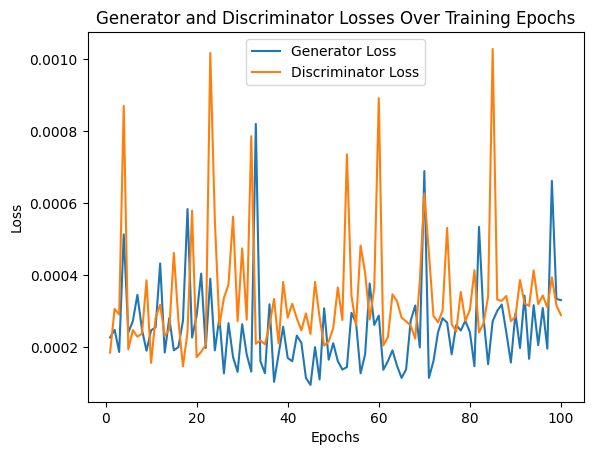

In [11]:
# Training parameters
epochs = 100
batch_size = 32
generator_losses=[]
discriminator_losses=[]
# Training loop
for epoch in range(epochs):
    # Train discriminator
    # Sample a random batch of real images and text embeddings
    idx = np.random.randint(0, len(real_images), batch_size)
    real_image_batch = real_images[idx]
    text_embedding_batch = text_embeddings[idx]

    # Generate a batch of fake images using random noise and text embeddings
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label real and fake images
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train discriminator on real and fake images separately
    real_loss = discriminator.train_on_batch([real_image_batch, text_embedding_batch], real_labels)
    fake_loss = discriminator.train_on_batch([fake_image_batch, text_embedding_batch], fake_labels)

    # Calculate discriminator loss
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)
    discriminator_losses.append(discriminator_loss[0])

    # Train generator
    # Generate another batch of fake images
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label fake images as real to fool the discriminator
    misleading_labels = np.ones((batch_size, 1))

    # Train generator to generate more realistic images
    generator_loss = cgan.train_on_batch([noise, text_embedding_batch], misleading_labels)
    generator_losses.append(generator_loss)


    # Print training progress
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"    Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")
plt.plot(range(1, epochs+1), generator_losses, label='Generator Loss')
plt.plot(range(1, epochs+1), discriminator_losses, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses Over Training Epochs')
plt.legend()
plt.show()


generator.save('generator_model100.keras')
discriminator.save('discriminator_model100.keras')

new_filename = 'cgan_model_{timestamp}.keras'.format(timestamp=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))  # Or any other unique name
cgan.save(new_filename)


In [13]:
from tensorflow.keras.models import load_model


1/1 [==============================] - 0s 183ms/step


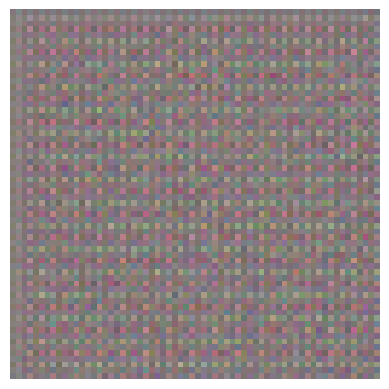

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
generator = load_model('generator_model100.keras')
# Function to generate an image based on a prompt
def generate_image_from_prompt(generator, word2vec_model, prompt_text):
    # Tokenize the prompt text and get its embedding
    prompt_tokens = word_tokenize(prompt_text.lower())
    prompt_embedding = np.zeros(word2vec_model.vector_size)
    count = 0
    for token in prompt_tokens:
        if token in word2vec_model.wv:
            prompt_embedding += word2vec_model.wv[token]
            count += 1
    if count != 0:
        prompt_embedding /= count

    # Generate random noise as input to the generator
    noise_input = np.random.randn(1, 100)

    # Reshape prompt embedding to match the expected input shape
    prompt_embedding_input = np.tile(prompt_embedding, (1, 1))

    # Generate the image using the generator model
    generated_image = generator.predict([noise_input, prompt_embedding_input])

    # Denormalize the generated image
    generated_image = (generated_image + 1) * 127.5
    generated_image = generated_image.astype(np.uint8)

    # Visualize the generated image
    generated_image = Image.fromarray(generated_image[0])
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()

prompt_text = "a logo of coffee shop"
# Generate an image based on the prompt
generate_image_from_prompt(generator, word2vec_model, prompt_text)


In [27]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize

def calculate_inception_score(generator, word2vec_model, num_samples=500, batch_size=50):
    # Initialize InceptionV3 model pretrained on ImageNet
    inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

    # Generate images and calculate activations
    generated_images = []
    for _ in range(num_samples // batch_size):
        # Generate random noise and text embeddings
        noise = np.random.randn(batch_size, 100)
        text_embeddings = np.random.randn(batch_size, word2vec_model.vector_size)

        # Generate images using the generator model
        generated_batch = generator.predict([noise, text_embeddings])
        generated_images.extend(generated_batch)

    # Resize generated images to (299, 299, 3) for InceptionV3 model
    resized_images = []
    for image in generated_images:
        resized_image = resize(image, (299, 299, 3), preserve_range=True)
        resized_images.append(resized_image)
    resized_images = np.array(resized_images)

    # Preprocess images for InceptionV3 model
    preprocessed_images = preprocess_input(resized_images)

    # Get activations of generated images from the InceptionV3 model
    activations = inception_model.predict(preprocessed_images)

    # Calculate the mean and standard deviation of activations
    mean_activations = np.mean(activations, axis=0)
    std_activations = np.std(activations, axis=0)

    # Calculate the Inception Score
    scores = []
    epsilon = 1e-10  # Small epsilon value to avoid numerical instability
    for activation in activations:
        kl_score = np.sum(activation * (np.log(activation + epsilon) - np.log(mean_activations + epsilon)))
        scores.append(np.exp(kl_score))
    inception_score = np.mean(scores)

    return inception_score

# Example usage:
inception_score = calculate_inception_score(generator, word2vec_model, num_samples=500, batch_size=50)
print("Inception Score:", inception_score)


16/16 [==============================] - 123s 8s/step
Inception Score: 3.9947908


# for 300 epoch


1/1 [==============================] - 0s 195ms/step
Epoch 1/300:
    Discriminator Loss: 0.00034010951276286505, Generator Loss: 0.0002917840611189604
1/1 [==============================] - 0s 302ms/step
Epoch 2/300:
    Discriminator Loss: 0.0002552592122810893, Generator Loss: 0.00025811692466959357
1/1 [==============================] - 0s 179ms/step
Epoch 3/300:
    Discriminator Loss: 0.0006368234753608704, Generator Loss: 0.00027502543525770307
1/1 [==============================] - 0s 209ms/step
Epoch 4/300:
    Discriminator Loss: 0.00033695313322823495, Generator Loss: 0.0003202325024176389
1/1 [==============================] - 0s 202ms/step
Epoch 5/300:
    Discriminator Loss: 0.0002764079144981224, Generator Loss: 0.00037499144673347473
1/1 [==============================] - 0s 187ms/step
Epoch 6/300:
    Discriminator Loss: 0.0002508889574528439, Generator Loss: 0.0006610501441173255
1/1 [==============================] - 0s 200ms/step
Epoch 7/300:
    Discriminator Loss:

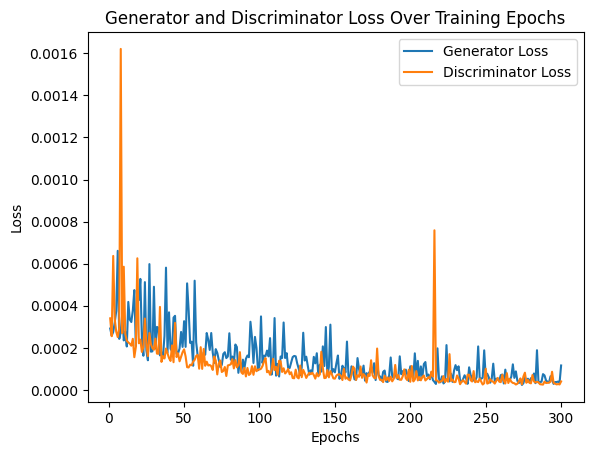

In [15]:
# Training parameters
epochs = 300
batch_size = 32

generator_loss= []
discriminator_losses = []
# Training loop
for epoch in range(epochs):
    # Train discriminator
    # Sample a random batch of real images and text embeddings
    idx = np.random.randint(0, len(real_images), batch_size)
    real_image_batch = real_images[idx]
    text_embedding_batch = text_embeddings[idx]

    # Generate a batch of fake images using random noise and text embeddings
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label real and fake images
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train discriminator on real and fake images separately
    real_loss = discriminator.train_on_batch([real_image_batch, text_embedding_batch], real_labels)
    fake_loss = discriminator.train_on_batch([fake_image_batch, text_embedding_batch], fake_labels)

    # Calculate discriminator loss
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)
    discriminator_losses.append(discriminator_loss[0])

    # Train generator
    # Generate another batch of fake images
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label fake images as real to fool the discriminator
    misleading_labels = np.ones((batch_size, 1))

    # Train generator to generate more realistic images
    current_generator_loss  = cgan.train_on_batch([noise, text_embedding_batch], misleading_labels)
    generator_loss.append(current_generator_loss)  # Appending to the list


    # Print training progress
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"    Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {current_generator_loss }")
plt.plot(range(1, epochs+1), generator_loss, label='Generator Loss')
plt.plot(range(1, epochs+1), discriminator_losses, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss Over Training Epochs')
plt.legend()
plt.show()

# After training, you can save the models if desired
generator.save('generator_model300.keras')
discriminator.save('discriminator_model300.keras')

new_filename = 'cgan_model_{timestamp}.keras'.format(timestamp=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))  # Or any other unique name
cgan.save(new_filename)

1/1 [==============================] - 0s 148ms/step


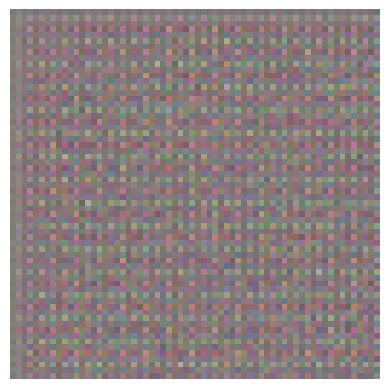

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
generator = load_model('generator_model300.keras')
def generate_image_from_prompt(generator, word2vec_model, prompt_text):
    # Tokenize the prompt text and get its embedding
    prompt_tokens = word_tokenize(prompt_text.lower())
    prompt_embedding = np.zeros(word2vec_model.vector_size)
    count = 0
    for token in prompt_tokens:
        if token in word2vec_model.wv:
            prompt_embedding += word2vec_model.wv[token]
            count += 1
    if count != 0:
        prompt_embedding /= count

    # Generate random noise as input to the generator
    noise_input = np.random.randn(1, 100)

    # Reshape prompt embedding to match the expected input shape
    prompt_embedding_input = np.tile(prompt_embedding, (1, 1))

    # Generate the image using the generator model
    generated_image = generator.predict([noise_input, prompt_embedding_input])

    # Denormalize the generated image
    generated_image = (generated_image + 1) * 127.5
    generated_image = generated_image.astype(np.uint8)

    # Visualize the generated image
    generated_image = Image.fromarray(generated_image[0])
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()

prompt_text = "a logo of coffee shop, image of a filled cup with steam in a square, white background, black, darkgray foreground, minimalism, modern"

# Generate an image based on the prompt
generate_image_from_prompt(generator, word2vec_model, prompt_text)


In [32]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize
from keras.models import load_model

def calculate_inception_score(generator_model_path, word2vec_model, num_samples=500, batch_size=50):
    # Load the generator model
    generator = load_model(generator_model_path)

    # Initialize InceptionV3 model pretrained on ImageNet
    inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

    # Generate images and calculate activations
    generated_images = []
    for _ in range(num_samples // batch_size):
        # Generate random noise and text embeddings
        noise = np.random.randn(batch_size, 100)
        text_embeddings = np.random.randn(batch_size, word2vec_model.vector_size)

        # Generate images using the generator model
        generated_batch = generator.predict([noise, text_embeddings])
        generated_images.extend(generated_batch)

    # Resize generated images to (299, 299, 3) for InceptionV3 model
    resized_images = []
    for image in generated_images:
        resized_image = resize(image, (299, 299, 3), preserve_range=True)
        resized_images.append(resized_image)
    resized_images = np.array(resized_images)

    # Preprocess images for InceptionV3 model
    preprocessed_images = preprocess_input(resized_images)

    # Get activations of generated images from the InceptionV3 model
    activations = inception_model.predict(preprocessed_images)

    # Calculate the mean and standard deviation of activations
    mean_activations = np.mean(activations, axis=0)
    std_activations = np.std(activations, axis=0)

    # Calculate the Inception Score
    scores = []
    epsilon = 1e-10  # Small epsilon value to avoid numerical instability
    for activation in activations:
        kl_score = np.sum(activation * (np.log(activation + epsilon) - np.log(mean_activations + epsilon)))
        scores.append(np.exp(kl_score))
    inception_score = np.mean(scores)

    return inception_score

# Example usage:
generator_model_path = 'generator_model300.keras'  # Path to the saved generator model
inception_score = calculate_inception_score(generator_model_path, word2vec_model, num_samples=500, batch_size=50)
print("Inception Score:", inception_score)


16/16 [==============================] - 123s 8s/step
Inception Score: 3.2692263


In [ ]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize
from keras.models import load_model

def calculate_inception_score(generator_model_path, word2vec_model, num_samples=500, batch_size=50):
    # Load the generator model
    generator = load_model(generator_model_path)

    # Initialize InceptionV3 model pretrained on ImageNet
    inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

    # Generate images and calculate activations
    generated_images = []
    for _ in range(num_samples // batch_size):
        # Generate random noise and text embeddings
        noise = np.random.randn(batch_size, 100)
        text_embeddings = np.random.randn(batch_size, word2vec_model.vector_size)

        # Generate images using the generator model
        generated_batch = generator.predict([noise, text_embeddings])
        generated_images.extend(generated_batch)

    # Resize generated images to (299, 299, 3) for InceptionV3 model
    resized_images = []
    for image in generated_images:
        resized_image = resize(image, (299, 299, 3), preserve_range=True)
        resized_images.append(resized_image)
    resized_images = np.array(resized_images)

    # Preprocess images for InceptionV3 model
    preprocessed_images = preprocess_input(resized_images)

    # Get activations of generated images from the InceptionV3 model
    activations = inception_model.predict(preprocessed_images)

    # Calculate the mean and standard deviation of activations
    mean_activations = np.mean(activations, axis=0)
    std_activations = np.std(activations, axis=0)

    # Calculate the Inception Score
    scores = []
    epsilon = 1e-10  # Small epsilon value to avoid numerical instability
    for activation in activations:
        kl_score = np.sum(activation * (np.log(activation + epsilon) - np.log(mean_activations + epsilon)))
        scores.append(np.exp(kl_score))
    inception_score = np.mean(scores)

    return inception_score

# Example usage:
generator_model_path = 'generator_model300.keras'  # Path to the saved generator model
inception_score = calculate_inception_score(generator_model_path, word2vec_model, num_samples=500, batch_size=50)
print("Inception Score:", inception_score)


 2/16 [==>...........................] - ETA: 1:49

FOR 500 EPOCHS


1/1 [==============================] - 0s 228ms/step
Epoch 1/500:
    Discriminator Loss: 5.445875649456866e-05, Generator Loss: 2.099465564242564e-05
1/1 [==============================] - 0s 206ms/step
Epoch 2/500:
    Discriminator Loss: 2.0938629859301727e-05, Generator Loss: 3.729039235622622e-05
1/1 [==============================] - 0s 213ms/step
Epoch 3/500:
    Discriminator Loss: 2.9480597731890157e-05, Generator Loss: 2.7925976610276848e-05
1/1 [==============================] - 0s 223ms/step
Epoch 4/500:
    Discriminator Loss: 1.8817995623976458e-05, Generator Loss: 5.734847218263894e-05
1/1 [==============================] - 0s 212ms/step
Epoch 5/500:
    Discriminator Loss: 1.550666002003709e-05, Generator Loss: 4.399755198392086e-05
1/1 [==============================] - 0s 355ms/step
Epoch 6/500:
    Discriminator Loss: 1.9620307284640148e-05, Generator Loss: 1.752177922753617e-05
1/1 [==============================] - 0s 211ms/step
Epoch 7/500:
    Discriminator Loss:

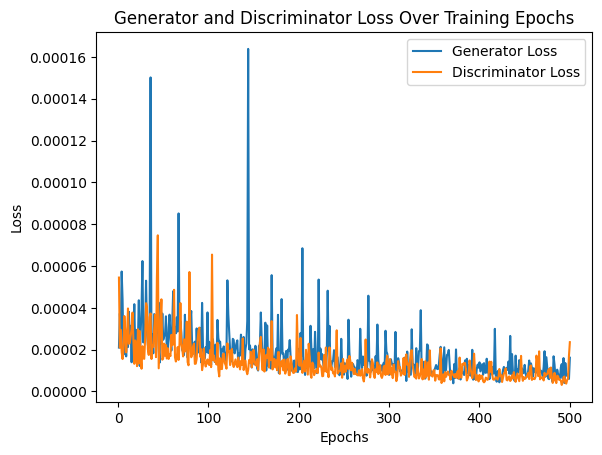

In [35]:
# Training parameters
epochs = 500
batch_size = 32
discriminator_losses = []
generator_losses = []  # Changed variable name to avoid confusion with the list

# Training loop
for epoch in range(epochs):
    # Train discriminator
    # Sample a random batch of real images and text embeddings
    idx = np.random.randint(0, len(real_images), batch_size)
    real_image_batch = real_images[idx]
    text_embedding_batch = text_embeddings[idx]

    # Generate a batch of fake images using random noise and text embeddings
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label real and fake images
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train discriminator on real and fake images separately
    real_loss = discriminator.train_on_batch([real_image_batch, text_embedding_batch], real_labels)
    fake_loss = discriminator.train_on_batch([fake_image_batch, text_embedding_batch], fake_labels)

    # Calculate discriminator loss
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)
    discriminator_losses.append(discriminator_loss[0])


    # Train generator
    # Generate another batch of fake images
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label fake images as real to fool the discriminator
    misleading_labels = np.ones((batch_size, 1))

    # Train generator to generate more realistic images
    generator_loss = cgan.train_on_batch([noise, text_embedding_batch], misleading_labels)

    # Print training progress
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"    Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")
    generator_losses.append(generator_loss)

# Plot generator and discriminator loss
plt.plot(range(1, epochs+1), generator_losses, label='Generator Loss')
plt.plot(range(1, epochs+1), discriminator_losses, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss Over Training Epochs')
plt.legend()
plt.show()
generator.save('generator_model500.keras')
discriminator.save('discriminator_model500.keras')

new_filename = 'cgan_model_{timestamp}.keras'.format(timestamp=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))  # Or any other unique name
cgan.save(new_filename)

1/1 [==============================] - 0s 179ms/step


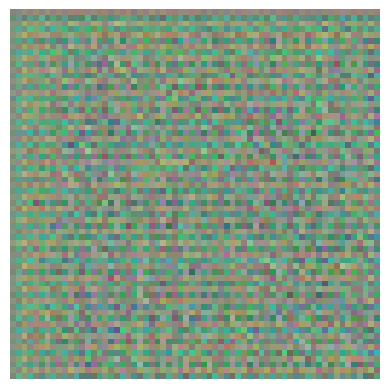

In [43]:

from PIL import Image
import matplotlib.pyplot as plt
generator = load_model('generator_model.keras')
new_filename = 'cgan_model_{timestamp}.keras'.format(timestamp=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))  # Or any other unique name
cgan.save(new_filename)

def generate_image_from_prompt(generator, word2vec_model, prompt_text):
    # Tokenize the prompt text and get its embedding
    prompt_tokens = word_tokenize(prompt_text.lower())
    prompt_embedding = np.zeros(word2vec_model.vector_size)
    count = 0
    for token in prompt_tokens:
        if token in word2vec_model.wv:
            prompt_embedding += word2vec_model.wv[token]
            count += 1
    if count != 0:
        prompt_embedding /= count

    # Generate random noise as input to the generator
    noise_input = np.random.randn(1, 100)

    # Reshape prompt embedding to match the expected input shape
    prompt_embedding_input = np.tile(prompt_embedding, (1, 1))

    # Generate the image using the generator model
    generated_image = generator.predict([noise_input, prompt_embedding_input])

    # Denormalize the generated image
    generated_image = (generated_image + 1) * 127.5
    generated_image = generated_image.astype(np.uint8)

    # Visualize the generated image
    generated_image = Image.fromarray(generated_image[0])
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()

prompt_text = "an apple is red"

# Generate an image based on the prompt
generate_image_from_prompt(generator, word2vec_model, prompt_text)

In [44]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize
from keras.models import load_model

def calculate_inception_score(generator_model_path, word2vec_model, num_samples=500, batch_size=50):
    # Load the generator model
    generator = load_model(generator_model_path)

    # Initialize InceptionV3 model pretrained on ImageNet
    inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

    # Generate images and calculate activations
    generated_images = []
    for _ in range(num_samples // batch_size):
        # Generate random noise and text embeddings
        noise = np.random.randn(batch_size, 100)
        text_embeddings = np.random.randn(batch_size, word2vec_model.vector_size)

        # Generate images using the generator model
        generated_batch = generator.predict([noise, text_embeddings])
        generated_images.extend(generated_batch)

    # Resize generated images to (299, 299, 3) for InceptionV3 model
    resized_images = []
    for image in generated_images:
        resized_image = resize(image, (299, 299, 3), preserve_range=True)
        resized_images.append(resized_image)
    resized_images = np.array(resized_images)

    # Preprocess images for InceptionV3 model
    preprocessed_images = preprocess_input(resized_images)

    # Get activations of generated images from the InceptionV3 model
    activations = inception_model.predict(preprocessed_images)

    # Calculate the mean and standard deviation of activations
    mean_activations = np.mean(activations, axis=0)
    std_activations = np.std(activations, axis=0)

    # Calculate the Inception Score
    scores = []
    epsilon = 1e-10  # Small epsilon value to avoid numerical instability
    for activation in activations:
        kl_score = np.sum(activation * (np.log(activation + epsilon) - np.log(mean_activations + epsilon)))
        scores.append(np.exp(kl_score))
    inception_score = np.mean(scores)

    return inception_score

# Example usage:
generator_model_path = 'generator_model.keras'  # Path to the saved generator model
inception_score = calculate_inception_score(generator_model_path, word2vec_model, num_samples=500, batch_size=50)
print("Inception Score:", inception_score)


16/16 [==============================] - 118s 7s/step
Inception Score: 3.1285596
